# DataStructure Design 
API name: `LookupTable`
### Usage
```
lookup_table = LookupTable(row_name, column_name)
lookup_table.insert_from_csv(*args, **kwargs) # Load from csv
lookup_table.insert(*args, **kwargs) # Insert a single entry
lookup_table.select(**kwargs) # Access the data
lookup_table.length # Show the length of the lookup table
```
### Constraints / Hypothesis made
- The order of the data in the csv files is important : Else we should consider using things like dynamic hashing DS with some custom Tree implementation.

In [2]:
import contextlib
from csv import DictReader
from collections import OrderedDict
from typing import Any


class logger:  # noqa
    log = staticmethod(print)  # noqa


class LookupTable(object):

    ASTERISK_CHARACTER = "*"
    NOT_PROVIDED = object()
    LIMIT_TO_LOAD_IN_MEMORY = 1_000_000

    LookupTableOperationError = type("LookupTableOperationError", (Exception,), {})

    def __init__(self, row_name: str, column_name: str):
        self.__row_name = row_name
        self.__column_name = column_name
        self.__data: OrderedDict = OrderedDict()

    @property
    def length(self):
        return len(self.__data)

    def select(self, **kwargs) -> list[Any] | Any:
        """
        Core lookup API for now
        """
        row = kwargs.pop(self.__row_name, self.ASTERISK_CHARACTER)
        column = kwargs.get(self.__column_name, self.ASTERISK_CHARACTER)

        values = None if self.ASTERISK_CHARACTER not in (row, column) else []

        # Using dynamic var as key is not necessary here, but done just for fun.
        predicates_mapping = {
            self.__row_name: lambda t, r, _: t[0] == r,
            self.__column_name: lambda t, _, c_: t[1] == c_,
        }

        with contextlib.suppress(KeyError):
            if row != self.ASTERISK_CHARACTER and column != self.ASTERISK_CHARACTER:
                # The user wants a singleton in this case
                return self.__data[(row, column)]

            elif row == self.ASTERISK_CHARACTER and column == self.ASTERISK_CHARACTER:
                # The client code wants us to return all the lookup value.

                predicate = None

            elif row == self.ASTERISK_CHARACTER:
                # The client code wants us to return all the rows for the given column
                predicate = predicates_mapping.get(self.__column_name)

                assert (
                    predicate is not None
                ), f"Predicate for column '{self.__column_name}' cannot be None when row is set to the asterisk ('*')."

            else:  # the case `column == self.ASTERISK_CHARACTER`
                # The client code wants us to return all the columns for the given row
                predicate = predicates_mapping.get(self.__row_name)
                assert (
                    predicate is not None
                ), f"Predicate for row '{self.__row_name}' cannot be None when column is set to the asterisk ('*')."

            for k in self.__data:
                if predicate and not predicate(k, row, column):
                    continue
                values.append(self.__data[k])
                if predicate and predicate(k, row, column):
                    values.append(self.__data[k])

            return values

    def insert(self, row_name: str, column_name: str, value: Any):
        self.__data[(row_name, column_name)] = value

    def insert_from_csv(
        self, *, row_header: str, column_header: str, file_path: str, verbose=True
    ):
        assert (
            row_header is None or row_header == self.__row_name
        ), f"Invalid row header provided: '{row_header}'. The row header must be either None or match the previously defined row header '{self.__row_name}'."
        assert (
            column_header is None or column_header == self.__column_name
        ), f"Invalid column header provided: '{column_header}'. The column header must be either None or match the previously defined column header '{self.__column_name}'."

        count = 0
        with open(file_path, mode="r", newline="") as csvfile:
            for line in DictReader(csvfile):
                count += 1

                lookup_key = line[row_header], line[column_header]
                # Here, we're supposing that the data in the csv file are normalized (DB normalization)
                if existing_lookup_value := self.__data.get(lookup_key):
                    existing_lookup_value.update(line)
                    continue

                lookup_key = line[row_header], line[column_header]
                self.__data[lookup_key] = line

                if count == self.LIMIT_TO_LOAD_IN_MEMORY:
                    logger.log(
                        f"Limit of entries (.i.e {self.LIMIT_TO_LOAD_IN_MEMORY}) to load has been reached. Exiting without loading the rest... "
                    )
                    break

        if not self.__row_name or not self.__column_name:
            self.__row_name = row_header
            self.__column_name = column_header

        if verbose:
            logger.log(f"Loaded {count} row(s) from '{file_path}' successfully.")

    def __getitem__(self, item):
        # FIXME: Have to think about the API first.
        # Can get some inspiration from numpy API.
        raise self.LookupTableOperationError(
            "Operation not supported, consider using the method `select`"
        )

    def __setitem__(self, key, value):
        raise self.LookupTableOperationError(
            "Operation not supported, consider using the method, `insert` or `insert_from_csv`"
        )


lookup_table = LookupTable(row_name="userId", column_name="movieId")

# Example Usage
lookup_table.insert_from_csv(
    file_path="./ml-32m/ratings.csv", row_header="userId", column_header="movieId"
)

print(lookup_table.select(userId="1", movieId="17"))

Limit of entries (.i.e 1000000) to load has been reached. Exiting without loading the rest... 
Loaded 1000000 row(s) from './ml-32m/ratings.csv' successfully.
{'userId': '1', 'movieId': '17', 'rating': '4.0', 'timestamp': '944249077'}


In [3]:
import unittest


class TestLookupTable(unittest.TestCase):
    def setUp(self):
        """Set up the LookupTable instance before each test"""
        self.lookup_table = LookupTable(row_name="row", column_name="col")

    def test_insert_and_select_single_entry(self):
        """Test setting and getting a single entry"""
        self.lookup_table.insert("row1", "col1", "value1")
        result = self.lookup_table.select(row="row1", col="col1")
        self.assertEqual(
            result,
            "value1",
            "Should return the exact value set for the row-column pair",
        )

    def test_select_with_asterisk_for_row(self):
        """Test lookup when row is '*' and a specific column is provided"""
        self.lookup_table.insert("row1", "col1", "value1")
        self.lookup_table.insert("row2", "col1", "value2")
        result = self.lookup_table.select(row="*", col="col1")
        self.assertEqual(
            result,
            ["value1", "value2"],
            "Should return all values for the column when row is '*'",
        )


if __name__ == "__main__":
    unittest.main()

E
ERROR: /home/hjisaac/ (unittest.loader._FailedTest./home/hjisaac/)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute '/home/hjisaac/'

----------------------------------------------------------------------
Ran 1 test in 0.001s

FAILED (errors=1)


SystemExit: True

/home/hjisaac/.cache/pypoetry/virtualenvs/codes-uSlwvUxw-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [43]:
print(lookup_table.select(userId="1", movieId="17"))

{'userId': '1', 'movieId': '17', 'rating': '4.0', 'timestamp': '944249077'}


In [44]:
lookup_table.insert_from_csv(
    file_path="./ml-32m/tags.csv", row_header="userId", column_header="movieId"
)

Loaded 2000072 rows from './ml-32m/tags.csv' successfully.


In [45]:
print(lookup_table.length)

1339363


In [46]:
lookup_table.select()

[{'userId': '1', 'movieId': '17', 'rating': '4.0', 'timestamp': '944249077'},
 {'userId': '1', 'movieId': '25', 'rating': '1.0', 'timestamp': '944250228'},
 {'userId': '1', 'movieId': '29', 'rating': '2.0', 'timestamp': '943230976'},
 {'userId': '1', 'movieId': '30', 'rating': '5.0', 'timestamp': '944249077'},
 {'userId': '1', 'movieId': '32', 'rating': '5.0', 'timestamp': '943228858'},
 {'userId': '1', 'movieId': '34', 'rating': '2.0', 'timestamp': '943228491'},
 {'userId': '1', 'movieId': '36', 'rating': '1.0', 'timestamp': '944249008'},
 {'userId': '1', 'movieId': '80', 'rating': '5.0', 'timestamp': '944248943'},
 {'userId': '1', 'movieId': '110', 'rating': '3.0', 'timestamp': '943231119'},
 {'userId': '1', 'movieId': '111', 'rating': '5.0', 'timestamp': '944249008'},
 {'userId': '1', 'movieId': '161', 'rating': '1.0', 'timestamp': '943231162'},
 {'userId': '1', 'movieId': '166', 'rating': '5.0', 'timestamp': '943228442'},
 {'userId': '1', 'movieId': '176', 'rating': '4.0', 'timesta

In [ ]:
%%sql


In [1]:
# lookup_table.select(movieId="17")

# Plot movie rating distribution

- We will first have to gather all the ratings across the dataset and then plots the distribution of the result

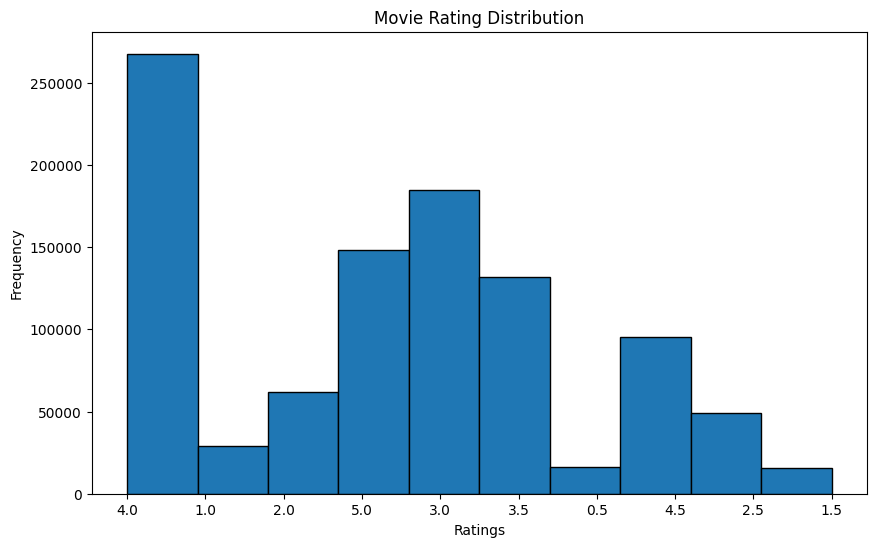

In [56]:
import matplotlib.pyplot as plt
from collections import Counter

ratings = [o["rating"] for o in lookup_table.select() if "rating" in o]

plt.figure(figsize=(10, 6))
plt.hist(ratings, bins=10, edgecolor="black")
plt.title("Movie Rating Distribution")
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.show()